Python: 3.8.12 (default, Oct 12 2021, 13:49:34) 
[GCC 7.5.0]
Numpy: 1.21.2
Torch: 1.10.0


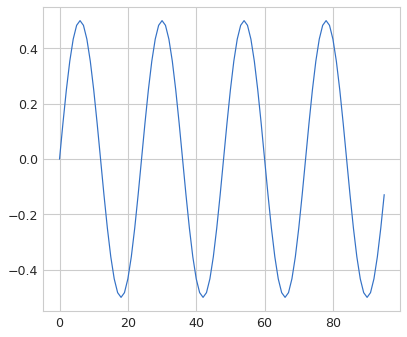

M=96
Signal Length M=96
maxmin = 1.0
std = 0.3535533905932738
Trainlength = 48


In [1]:
import sys
sys.path.insert(1,'/home/bwhiteak/ChaosESN/ESN_utils/')

import numpy as np
import torch
import rc_tools as rct
import rc_analysis as rca
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.optimize import fsolve
from scipy.signal import argrelextrema
import time

import pdb

from skopt.space import Real,Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

import warnings
warnings.filterwarnings("ignore")

from jupyterthemes import jtplot
jtplot.style()

np.random.seed(11)
torch.set_printoptions(precision=10)
torch.set_num_threads(4)
dtype = torch.float32 

print(f'Python: {sys.version}')
print(f'Numpy: {np.__version__}')
print(f'Torch: {torch.__version__}')

DEVICE = 'cuda:1'

T = 24
f = lambda x: 0.5*np.sin(2*np.pi*x/24)
signal = f(np.arange(4*T))
FREERUN = 0
plt.figure()
plt.plot(signal[:4*T])
plt.show()

M = signal.shape[0]-FREERUN

K = 1
L = 1
RF = .5
TEST = 24*2
LEAD = 24
BURNIN = 24
REG = 1e-8
TRAINLENGTH = M-TEST
print(f'M={M}')
MINMAX = np.max(signal[:TRAINLENGTH+TEST]) - np.min(signal[:TRAINLENGTH+TEST])
STD  = np.std(signal[:TRAINLENGTH+TEST])
print(f'Signal Length M={M}')
print(f'maxmin = {MINMAX}')
print(f'std = {STD}')
print(f'Trainlength = {TRAINLENGTH}')

###  Helper functions and plotting parameters

In [2]:
def get_weight_matricesGPU(k,n,l,ri,ro):
    win = torch.rand((n,k),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(ri)
    wfb = torch.zeros((n,l),dtype=dtype, device=torch.device(DEVICE))
    wout = torch.rand((l,n+k),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(ro)
    return win, wfb, wout

def set_vectorsGPU(n,l,r):
    x0 = torch.rand((n,1),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(r)
    y0 = torch.zeros((l,1),dtype=dtype, device=torch.device(DEVICE))
    return x0, y0

def update_res_stateGPU(wnet,xt,uxy,a,g):
    z = torch.matmul(wnet,uxy)
    return torch.mul(xt,1-a) + torch.mul(torch.tanh(z),a*g)

def predict_yGPU(wout,xu):
    return torch.matmul(wout, xu)

def get_matrixGPU(n,r,sr):
    A = (torch.rand((n,n),dtype=dtype,
                   device=torch.device(DEVICE))-.5)*r
    At = torch.transpose(A,0,1)
    D = torch.diag(torch.diag(A))   
    W = A + At - D
    eig = torch.eig(W, eigenvectors=False)
    wsr = torch.max(torch.abs(eig[0]))
    return W.div(wsr).mul(sr)

def resize_spaces(mn, mx, best, isAlpha=False):
    #pdb.set_trace()
    if(best.size==0):
        new_mn = np.max([0, mn - .5*mn])
        new_mx = 1.5*mx
    else:
        best_mn = np.min(best)
        best_mx = np.max(best)
        mn_bound = (best_mn-mn)/2
        mx_bound = (mx -best_mx)/2
        new_mn, new_mx = best_mn-mn_bound, best_mx+mx_bound
        print(f'\nBest mn:{best_mn:.3f}\t mn:{best_mx:.3f}')
        print(f'New bounds mn--mx: {mn_bound:.3f}--{mx_bound:.3f}')
    if(isAlpha):
        if(new_mx>1):
            new_mx = 1
    
    return new_mn, new_mx

import json
from json import JSONEncoder

# numpy arrays cannot be written to json 
# convert to list
class NumpyArrayEncoder(JSONEncoder):
    def default(self,obj):
        if isinstance(obj,np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self,obj)

fontsize = 24
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["text.usetex"] = True 
plt.rcParams["axes.xmargin"] = 0 
plt.rcParams["axes.titlesize"] = fontsize 
plt.rcParams["axes.labelsize"] = fontsize
plt.rcParams["xtick.labelsize"] = fontsize
plt.rcParams["ytick.labelsize"] = fontsize
plt.rcParams["axes.labelsize"] = fontsize
plt.rcParams["font.weight"] = "heavy"
plt.rcParams["axes.labelweight"] = "heavy"

### Save/load dicts

In [3]:
#with open('Dicts/diagX.json', 'w') as fp:
#    json.dump(dict_diag, fp, cls=NumpyArrayEncoder)
#with open('Dicts/modelsX.json', 'w') as fp:
#    json.dump(dict_models, fp, cls=NumpyArrayEncoder)

fpath = 'Dicts0/S1/diag_S1_long.json'
with open(fpath,'r') as j:
    dict_diag = json.loads(j.read())

fpath = 'Dicts0/S1/models_S1_long.json'
with open(fpath,'r') as j:
    dict_models = json.loads(j.read())

### Plot model counts

[64 62 59 63 58 72 66 75 81 76 70 70 71 72 73 91 77 86 89 86]
[ 38  55  66  73  71  96 117  88 106  89  98  93  92 102  59  62  63  63
  63  61]
[116 120 119 126 122 109 132 114 113 126 122 100 118 102 103 100 101 121
 108 124]
[0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 3 7 1 5 7]


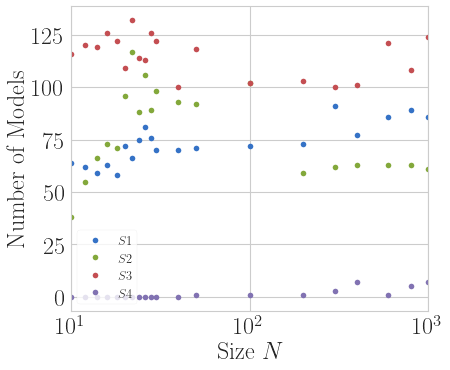

In [4]:
size = [1000,800,600,400,300,200,100,
        50,40,30,28,26,24,22,20,18,16,14,12,10]
ROUND=2

mean_errors = []
num_models = []


    
for i in size:
    try:
        err = np.max(dict_diag[str(i)]['meanError'])
    except:
        err = 0
    if(np.isnan(err)):
        err=0
    mean_errors.append(err)
    
    try:
        num = dict_diag[str(i)]['numModels']
    except:
        num = 0
    if(np.isnan(err)):
        num = 0
    num_models.append(num)
#np.save('num_modelsS1',num_models)

mname = ['num_modelsS1.npy','num_modelsS2.npy','num_modelsS3.npy','num_modelsS4.npy']
labels = ['$S1$','$S2$','$S3$','$S4$']
for i in range(len(mname)):
    num_models = np.load(mname[i])
    print(num_models[::-1])
    plt.semilogx(size[::-1],num_models[::-1],'o',label=labels[i])
plt.xlabel('Size $N$')
plt.ylabel('Number of Models')
plt.legend(loc='lower left')
plt.show()

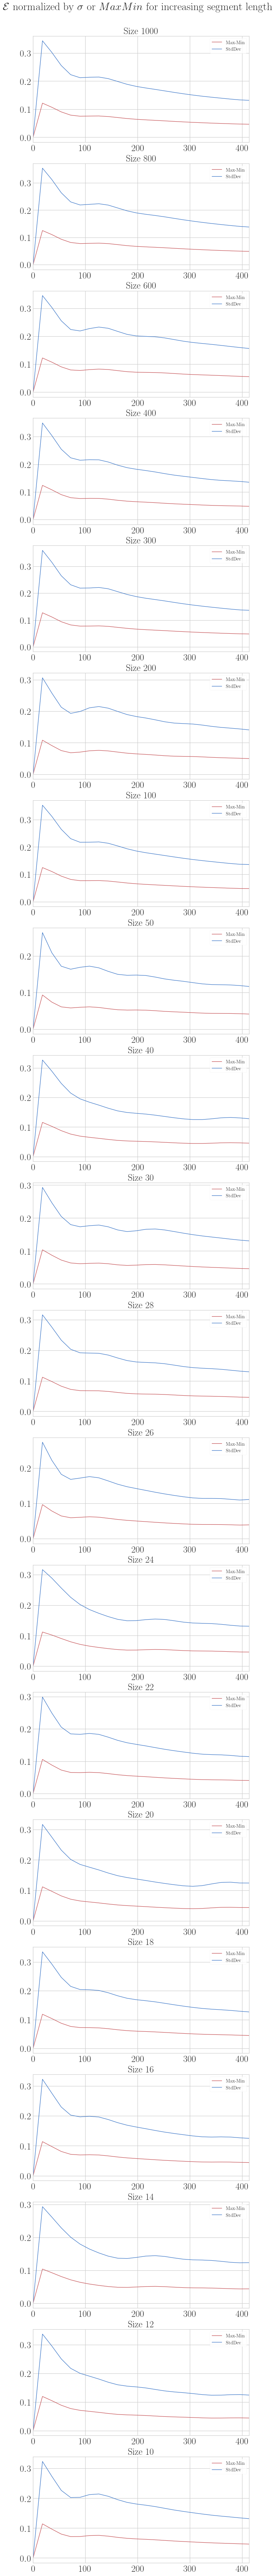

In [8]:
import pdb
def debug():
    #pdb.set_trace()
    Nplots= len(size)
    Nsegs = 24
    stpsz = 2
    segment_errMM = np.zeros((Nplots,Nsegs))
    segment_errSTD = np.zeros((Nplots,Nsegs))
    seglengths = np.zeros((1,Nsegs))
    for n in range(Nplots):
        try:
            preds = np.squeeze(np.array(dict_models[str(size[n])]['Preds']))
        except:
            print(f'Skipped {n}')
            continue
        for i in range(1,Nsegs):
            #print(f'{n}   {i}')
            sigchk = signal[TRAINLENGTH:TRAINLENGTH+i*stpsz]
            predschk = preds[TRAINLENGTH:TRAINLENGTH+i*stpsz]
            predschk = np.nan_to_num(predschk, nan=5)
            errMM = rca.NRMSE(sigchk,
                              predschk,
                              MINMAX)
            errSTD = rca.NRMSE(sigchk,
                               predschk,
                               STD)
            segment_errMM[n,i] = errMM
            segment_errSTD[n,i] = errSTD
            seglengths[0,i] = i*18

    fig, axs = plt.subplots(Nplots, figsize=(10,6*Nplots)) 
    fig.suptitle('$\mathcal{E}$ normalized by $\sigma$ or $MaxMin$ for increasing segment length'
                 , y=.89, fontsize=28)
    for n in range(Nplots):
        axs[n].set_title(f'Size {size[n]}')
        axs[n].plot(seglengths[0,:], segment_errMM[n,:],
                 color='r', label=f'Max-Min')
        axs[n].plot(seglengths[0,:], segment_errSTD[n,:],
                 color='b', label=f'StdDev')
        axs[n].legend()
    #fig.tight_layout()
    plt.show()
    
debug()

### Plot targets with prediction 

N=1000   Error = 0.047 KL-div = 0.52 E*kl=0.02
N=800   Error = 0.048 KL-div = 0.47 E*kl=0.02
N=600   Error = 0.054 KL-div = 0.55 E*kl=0.03
N=400   Error = 0.047 KL-div = 0.11 E*kl=0.01
N=300   Error = 0.048 KL-div = 0.63 E*kl=0.03
N=200   Error = 0.049 KL-div = 0.22 E*kl=0.01
N=100   Error = 0.049 KL-div = 0.43 E*kl=0.02
N=50   Error = 0.041 KL-div = 0.24 E*kl=0.01
N=40   Error = 0.045 KL-div = 0.55 E*kl=0.02
N=30   Error = 0.045 KL-div = 0.51 E*kl=0.02
N=28   Error = 0.045 KL-div = 0.24 E*kl=0.01
N=26   Error = 0.042 KL-div = 0.22 E*kl=0.01
N=24   Error = 0.047 KL-div = 0.24 E*kl=0.01
N=22   Error = 0.041 KL-div = 0.12 E*kl=0.0
N=20   Error = 0.047 KL-div = 0.22 E*kl=0.01
N=18   Error = 0.045 KL-div = 0.49 E*kl=0.02
N=16   Error = 0.045 KL-div = 0.26 E*kl=0.01
N=14   Error = 0.044 KL-div = 0.58 E*kl=0.03
N=12   Error = 0.043 KL-div = 0.65 E*kl=0.03
N=10   Error = 0.046 KL-div = 0.2 E*kl=0.01


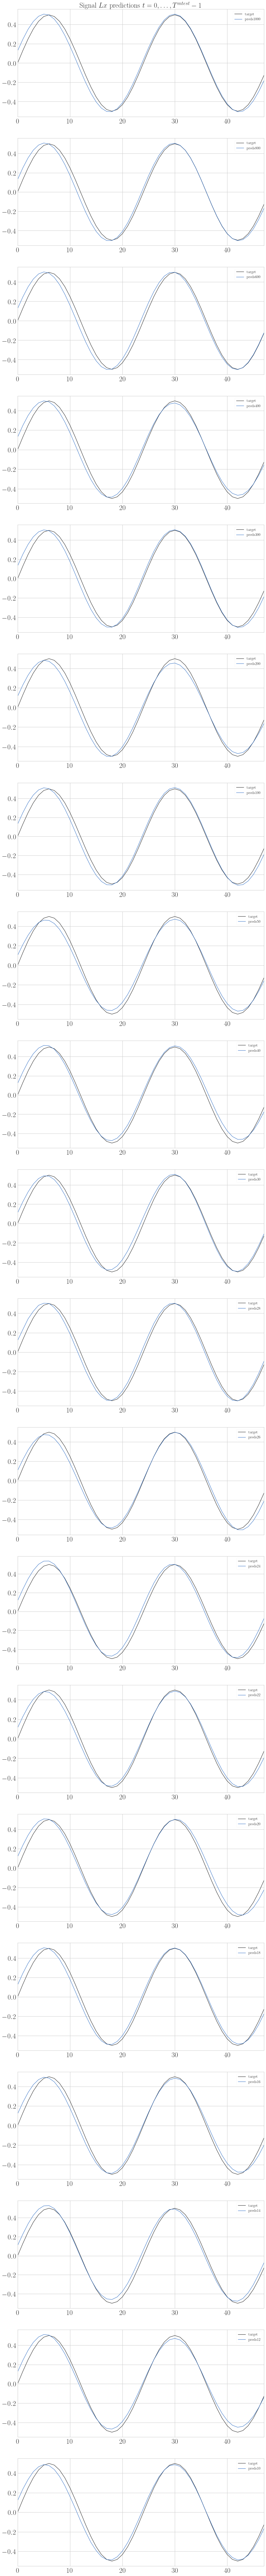

In [9]:
Nplots= len(size)
fig, axs = plt.subplots(Nplots, figsize=(15,8*Nplots)) 
axs[0].set_title('Signal $Lx$ predictions $t=0,\dots,T^{\rm test}-1$')
for n in range(Nplots):
    axs[n].plot(signal[TRAINLENGTH:TRAINLENGTH + TEST], color='k', label='target')
    preds = dict_models[str(size[n])]['Preds']
    error_testset = rca.NRMSE(signal[TRAINLENGTH:TRAINLENGTH + TEST],
                              preds[TRAINLENGTH:TRAINLENGTH + TEST],
                              MINMAX)
    kl,_,_,_ = rca.distribution(signal[TRAINLENGTH:TRAINLENGTH + TEST],
                                preds[TRAINLENGTH:TRAINLENGTH + TEST],
                                 np.min(signal[:TRAINLENGTH+TEST]),
                                 np.max(signal[:TRAINLENGTH+TEST]),
                                 bins=50)
    Ekl = error_testset*kl
    print(f'N={size[n]}   Error = {error_testset.round(3)} KL-div = {np.round(kl, ROUND)} E*kl={np.round(Ekl,ROUND)}')
    axs[n].plot(preds[TRAINLENGTH:TRAINLENGTH + TEST],
             color='b', label=f'preds{size[n]}')
    axs[n].legend()
plt.show()

### Get indicated rank to reduce to

In [ ]:
from scipy.optimize import fsolve
def rank_curve(cplus, tols):
    rank_tols = []
    for i in tols:
        rank_tols.append(rca.rank(cplus, i))
    return np.array(rank_tols)

all_ranks = []
K = 1
L = 1
tols = [1/10**x for x in range(0,20)]
np.zeros(len(size),)
plt.figure()
for n in size[:]:
    if(dict_diag[str(n)]['numModels']==0):
        all_ranks.append(0)
        continue
    mat = np.array(dict_models[str(n)]['Wnet'])
    Wr, Wi = rca.get_mats(None, K,n, matrix=mat)
    # params [alpha, spectralradius, gamma, ri, rr, loss]
    p = dict_models[str(n)]['Params']
    a,g = p[0], p[2]
    x0 = np.zeros((n,1))
    u0 = np.zeros((K,1))
    A = rca.leaky_jacobian(x0, u0, a, g, Wi, Wr)
    B = rca.partial_u(x0, u0, a, g, Wi, Wr)
    rhoA = np.max(np.abs(rca.eig_spectrum(A)))
    Cn = np.nan_to_num(rca.reachable_matrix(A,B))
    if(K != 3): # Square Cn
        Cn = Cn/np.max(np.abs(rca.eig_spectrum(Cn)))
    else:            # Non-square Cn
        Cn = Cn/np.max(np.abs(np.linalg.svd(Cn, compute_uv=False)))

    rkc = rank_curve(Cn, tols)
    grads = np.gradient(rkc)
    v = np.argmax(grads)
    plt.plot(rkc, label=f'N={n}')
    plt.vlines([v],0,50, color='k')
    if(v+1 == 20):
        ave_rank = (rkc[v]+rkc[v-1])//2
    else:
        ave_rank = (rkc[v]+rkc[v+1])//2
    print(f'Targeted reduced rank for N={n} is {ave_rank}\nValue v= {v} Tolerance {tols[v]} Rho A {rhoA.round(ROUND)}')
    print(f'Alpha {np.round(a,ROUND)} --- Gamma {np.round(g,ROUND)}\n')
    all_ranks.append(ave_rank)
plt.ylim(0,50)
plt.show()

### Log-Log Plot rank vs size

In [ ]:
rsize = size[::-1]

plt.loglog(rsize[:],all_ranks[::-1], label='indicated')
plt.loglog(rsize[:],rsize[:], label='N')
plt.xlabel('Size $N$')
plt.ylabel('$\mathrm{rank}(C_N)$')
plt.grid(True, which="both", ls="-")
plt.legend()
plt.show()

In [ ]:
mean_error = []
for i in size:
    err = dict_diag[str(i)]['meanError']
    mean_error.append(err)
    print(f'N={i}   number {np.round(err,ROUND)}')

### Get time-step of divergence 

In [ ]:
def Rxy(x,y):
    return np.dot(x.T,y)/(np.linalg.norm(x)*np.linalg.norm(y))
T = M + FREERUN
Nsizes = len(size)
correlations = np.zeros((Nsizes,T))
thresholds = np.zeros(Nsizes)
threshold_location = np.zeros(Nsizes, dtype=int)
for i in range(Nsizes): 
    k = 24
    corr_length = T-k # calculate for j= 0,..., M-k
    pred = np.array(dict_models[str(size[i])]['Preds']) # Get size N predictions
    
    for j in range(corr_length):
        tar = signal[j:j+k].reshape((k,1))
        prd = pred[j:j+k].reshape((k,1))
        correlations[i,j] = Rxy(tar,prd)

    minVal = correlations[i,TRAINLENGTH-8:TRAINLENGTH].min()
    thresholds[i] = minVal*.95
    threshold_location[i] = np.where(correlations[i,TRAINLENGTH:]<thresholds[i])[0][0]
    print(f'k=N={k} Trainingset min={minVal.round(3)}  threshold={thresholds[i]:.3f}',
          f' Location={threshold_location[i]}')

### Plot divergence

In [ ]:
LEAD = 24
mx = np.max(np.abs(signal))
fig, axs = plt.subplots(Nplots, figsize=(15,8*Nplots)) 
for n in range(Nsizes):
    pred = dict_models[str(size[n])]['Preds']
    axs[n].set_ylim(-1.5,1.5)
    axs[n].plot(signal[:TRAINLENGTH+TEST]/mx, color='k', label='target')
    axs[n].plot(pred[:TRAINLENGTH+TEST]/mx,color='b', label='pred')
    axs[n].plot(correlations[n,:TRAINLENGTH+TEST], color='r', label=f'k={size[n]}')
    axs[n].axvline(TRAINLENGTH+threshold_location[n],color='r', linestyle='dashed', label=f't={threshold_location[n]}')
    axs[n].axvline(TRAINLENGTH,color='k')
    axs[n].axhline(thresholds[n],color='r', linestyle='dotted')
    axs[n].set_ylabel('$\mathbf{R}_{xy}[k]\enspace ,\enspace Lx$')
    axs[n].set_xlabel('Time-steps $t$')
    axs[n].legend(fontsize=24,loc='lower right')
axs[0].set_title('Correlation (solid red) at $t$-step (dashed red), $\mathbf{R}_{xy}[k]<\mathrm{threshold}$ (dotted red) ')
plt.show()